In [1]:
import os
import optuna
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from dotenv import load_dotenv
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm
load_dotenv()

/Users/hanyuwu/Library/Caches/pypoetry/virtualenvs/stock-volatility-prediction-5RuW2YLE-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
# Global Variables
api_key = os.getenv('FMP_API_KEY')
ticker = 'NVDA'
start_date = '2018-01-01'
end_date = '2024-01-01'

In [3]:
url = f"https://financialmodelingprep.com/api/v3/historical-price-full/{ticker}?from={start_date}&to={end_date}&apikey={api_key}"
response = requests.get(url).json()

In [4]:
data = pd.DataFrame(response["historical"])
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(by='date').reset_index(drop=True)
data["return"] = data["close"].pct_change()
data["return_squared"] = data["return"] ** 2
data["realized_vol"] = data["return"].rolling(window=5).std()
# data.reset_index(drop=True, inplace=True)
# data = data.iloc[1:].reset_index(drop=True)

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(data["date"], data["realized_vol"])
plt.title('Realized Volatility- NVDA')
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.show()

In [9]:
ret = data["return"].iloc[1:]
realized_vol = ret.rolling(5).std()
realized_vol = pd.DataFrame(realized_vol)
realized_vol.reset_index(drop=True, inplace=True)

In [10]:
realized_vol

,return
0,NaN
1,NaN
2,NaN
3,NaN
4,0.027157
...,...
1503,0.021960
1504,0.018554
1505,0.018309
1506,0.008242


In [11]:
returns_svm = ret ** 2

In [13]:
returns_svm.reset_index(drop=True, inplace=True)

In [14]:
X = pd.concat([realized_vol, returns_svm], axis=1, ignore_index=True)

In [15]:
X

,0,1
0,NaN,4.331034e-03
1,NaN,2.778433e-05
2,NaN,7.101376e-05
3,NaN,9.388506e-04
4,0.027157,3.246490e-08
...,...,...
1503,0.021960,1.066658e-05
1504,0.018554,8.455109e-05
1505,0.018309,7.842137e-06
1506,0.008242,4.514668e-06


In [18]:
X = X[4:].copy()
X = X.reset_index(drop=True)

In [19]:
X

,0,1
0,0.027157,3.246490e-08
1,0.011820,6.004923e-05
2,0.012290,3.197906e-06
3,0.013983,2.498215e-05
4,0.007689,1.622493e-04
...,...,...
1499,0.021960,1.066658e-05
1500,0.018554,8.455109e-05
1501,0.018309,7.842137e-06
1502,0.008242,4.514668e-06


In [20]:
realized_vol = realized_vol.dropna().reset_index(drop=True)

In [21]:
realized_vol

,return
0,0.027157
1,0.011820
2,0.012290
3,0.013983
4,0.007689
...,...
1499,0.021960
1500,0.018554
1501,0.018309
1502,0.008242


In [22]:
n = int(len(X) * 0.8)
print(n)
svr_rbf = SVR(kernel='rbf')

1203


In [24]:
def objective(trial):
    gamma = trial.suggest_loguniform('gamma', 1e-5, 1e2)
    C = trial.suggest_loguniform('C', 1e-5, 1e2)
    epsilon = trial.suggest_loguniform('epsilon', 1e-5, 1e2)
    
    svr_rbf = SVR(kernel='rbf', gamma=gamma, C=C, epsilon=epsilon)
    svr_rbf.fit(X.iloc[:-n].values, realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
    predictions = svr_rbf.predict(X.iloc[n:])
    mse = mean_squared_error(realized_vol.iloc[n:], predictions)
    return mse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

best_params = study.best_params

[I 2024-04-25 00:18:03,112] A new study created in memory with name: no-name-cc03de2c-1224-47f5-bb6c-1461c02457b2
[I 2024-04-25 00:18:03,117] Trial 0 finished with value: 0.0008842123189937326 and parameters: {'gamma': 0.00020270409348593408, 'C': 0.12716548407566272, 'epsilon': 5.603965312103533}. Best is trial 0 with value: 0.0008842123189937326.
[I 2024-04-25 00:18:03,127] Trial 1 finished with value: 0.0003314261045934158 and parameters: {'gamma': 0.0022541416510775225, 'C': 0.0005976293354747728, 'epsilon': 3.713622014676757e-05}. Best is trial 1 with value: 0.0003314261045934158.
[I 2024-04-25 00:18:03,129] Trial 2 finished with value: 0.0008842123189937356 and parameters: {'gamma': 0.0006610244417702862, 'C': 0.0011286045654095025, 'epsilon': 0.21121365819992438}. Best is trial 1 with value: 0.0003314261045934158.
[I 2024-04-25 00:18:03,132] Trial 3 finished with value: 0.0008842123189937367 and parameters: {'gamma': 0.00020326761217589153, 'C': 0.0009566139637517064, 'epsilon':

In [25]:
print(f"Best Params: {best_params}")

Best Params: {'gamma': 11.586177489141342, 'C': 0.08188159541276764, 'epsilon': 5.520253765841874e-05}


In [26]:
svr_rbf = SVR(kernel='rbf', **best_params)

In [28]:
svr_rbf.fit(X.iloc[:-n].values, realized_vol.iloc[1:-(n-1)].values.reshape(-1,))

SVR(C=0.08188159541276764, epsilon=5.520253765841874e-05,
    gamma=11.586177489141342)

In [29]:
predict_svr_rbf = svr_rbf.predict(X.iloc[n:])

In [31]:
test_set = pd.DataFrame({'Realized Volatility': realized_vol.iloc[n:].values.reshape(-1,), 'Predicted Volatility': predict_svr_rbf})

Text(0, 0.5, 'Volatility')

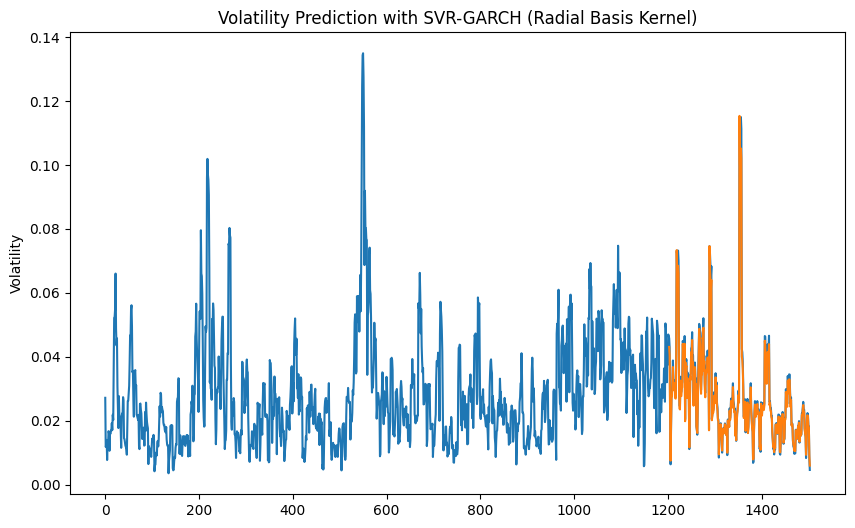

In [36]:
test_set.index = realized_vol.index[n:]
plt.figure(figsize=(10, 6))
plt.plot(realized_vol, label='Realized Volatility')
plt.plot(test_set['Predicted Volatility'], label='Predicted Volatility')
plt.title('Volatility Prediction with SVR-GARCH (Radial Basis Kernel)', fontsize=12)
plt.ylabel('Volatility')

In [ ]:
data_list = []

for page in tqdm(range(300)):
    url = f'https://financialmodelingprep.com/api/v3/stock_news?tickers={ticker}&page={page}&apikey={api_key}'

    response = requests.get(url).json()

    for item in response:
        data_list.append({'text': item['text'], 'publishedDate': item['publishedDate']})

news_data = pd.DataFrame(data_list)

news_data.head()

In [ ]:
news_data

In [ ]:
pd.to_datetime(news_data['publishedDate']).dt.date

In [ ]:
data_list = []

for page in tqdm(range(200)):
    url = f'https://financialmodelingprep.com/api/v4/historical/social-sentiment?symbol={ticker}&page={page}&apikey={api_key}'

    response = requests.get(url).json()

    for item in response:
        data_list.append({  "date": item["date"],
        "symbol": item["symbol"],
        "stocktwitsPosts": item["stocktwitsPosts"],
        "twitterPosts": item["twitterPosts"],
        "stocktwitsComments": item["stocktwitsComments"],
        "twitterComments": item["twitterComments"],
        "stocktwitsLikes": item["stocktwitsLikes"],
        "twitterLikes": item["twitterLikes"],
        "stocktwitsImpressions": item["stocktwitsImpressions"],
        "twitterImpressions": item["twitterImpressions"],
        "stocktwitsSentiment": item["stocktwitsSentiment"],
        "twitterSentiment": item["twitterSentiment"],
        })

twitter_data = pd.DataFrame(data_list)

twitter_data.head()

In [ ]:
len(pd.to_datetime(twitter_data['date']).dt.date.unique())